In [1]:
import os
import shutil
import tarfile
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
import pandas as pd
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import seaborn as sns 
from wordcloud import WordCloud, STOPWORDS # type: ignore
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

/Users/prabhnoorsingh/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/Users/prabhnoorsingh/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [4]:
# Get the current working directory
current_folder = os.getcwd()

dataset = tf.keras.utils.get_file(
    fname ="aclImdb.tar.gz", 
    origin ="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
    cache_dir=  current_folder,
    extract = True)

84125825/84125825 ━━━━━━━━━━━━━━━━━━━━ 187s 2us/step


In [5]:
dataset_path = os.path.dirname(dataset)
# Check the dataset
os.listdir(dataset_path)

['aclImdb', 'aclImdb.tar.gz']

In [6]:
# Dataset directory
dataset_dir = os.path.join(dataset_path, 'aclImdb')

# Check the Dataset directory
os.listdir(dataset_dir)

['imdbEr.txt', 'test', 'imdb.vocab', 'README', 'train']

In [7]:
train_dir = os.path.join(dataset_dir,'train')
os.listdir(train_dir)

['urls_unsup.txt',
 'neg',
 'urls_pos.txt',
 'unsup',
 'urls_neg.txt',
 'pos',
 'unsupBow.feat',
 'labeledBow.feat']

In [8]:
for file in os.listdir(train_dir):
    file_path = os.path.join(train_dir, file)
    # Check if it's a file (not a directory)
    if os.path.isfile(file_path): 
        with open(file_path, 'r', encoding='utf-8') as f:
            first_value = f.readline().strip()
            print(f"{file}: {first_value}")
    else:
        print(f"{file}: {file_path}")

urls_unsup.txt: http://www.imdb.com/title/tt0018515/usercomments
neg: /Users/prabhnoorsingh/Documents/sentiment_analysis_bert/notebooks/datasets/aclImdb/train/neg
urls_pos.txt: http://www.imdb.com/title/tt0453418/usercomments
unsup: /Users/prabhnoorsingh/Documents/sentiment_analysis_bert/notebooks/datasets/aclImdb/train/unsup
urls_neg.txt: http://www.imdb.com/title/tt0064354/usercomments
pos: /Users/prabhnoorsingh/Documents/sentiment_analysis_bert/notebooks/datasets/aclImdb/train/pos
unsupBow.feat: 0 0:8 1:6 3:5 4:2 5:1 7:1 8:5 9:2 10:1 11:2 13:3 16:1 17:1 18:1 19:1 22:3 24:1 26:3 28:1 30:1 31:1 35:2 36:1 39:2 40:1 41:2 46:2 47:1 48:1 52:1 63:1 67:1 68:1 74:1 81:1 83:1 87:1 104:1 105:1 112:1 117:1 131:1 151:1 155:1 170:1 198:1 225:1 226:1 288:2 291:1 320:1 331:1 342:1 364:1 374:1 384:2 385:1 407:1 437:1 441:1 465:1 468:1 470:1 519:1 595:1 615:1 650:1 692:1 851:1 937:1 940:1 1100:1 1264:1 1297:1 1317:1 1514:1 1728:1 1793:1 1948:1 2088:1 2257:1 2358:1 2584:2 2645:1 2735:1 3050:1 4297:1 5

In [9]:
def load_dataset(directory):
    data = {"sentence": [], "sentiment": []}
    for file_name in os.listdir(directory):
        print(file_name)
        if file_name == 'pos':
            positive_dir = os.path.join(directory, file_name)
            for text_file in os.listdir(positive_dir):
                text = os.path.join(positive_dir, text_file)
                with open(text, "r", encoding="utf-8") as f:
                    data["sentence"].append(f.read())
                    data["sentiment"].append(1)
        elif file_name == 'neg':
            negative_dir = os.path.join(directory, file_name)
            for text_file in os.listdir(negative_dir):
                text = os.path.join(negative_dir, text_file)
                with open(text, "r", encoding="utf-8") as f:
                    data["sentence"].append(f.read())
                    data["sentiment"].append(0)
            
    return pd.DataFrame.from_dict(data)

In [10]:
# Load the dataset from the train_dir
train_df = load_dataset(train_dir)
print(train_df.head())

urls_unsup.txt
neg
urls_pos.txt
unsup
urls_neg.txt
pos
unsupBow.feat
labeledBow.feat
                                            sentence  sentiment
0  Working with one of the best Shakespeare sourc...          0
1  Well...tremors I, the original started off in ...          0
2  Ouch! This one was a bit painful to sit throug...          0
3  I've seen some crappy movies in my life, but t...          0
4  "Carriers" follows the exploits of two guys an...          0


In [11]:
test_dir = os.path.join(dataset_dir,'test')

# Load the dataset from the train_dir
test_df = load_dataset(test_dir)
print(test_df.head())

neg
urls_pos.txt
urls_neg.txt
pos
labeledBow.feat
                                            sentence  sentiment
0  Alan Rickman & Emma Thompson give good perform...          0
1  I have seen this movie and I did not care for ...          0
2  In Los Angeles, the alcoholic and lazy Hank Ch...          0
3  This film is bundled along with "Gli fumavano ...          0
4  I only comment on really very good films and o...          0


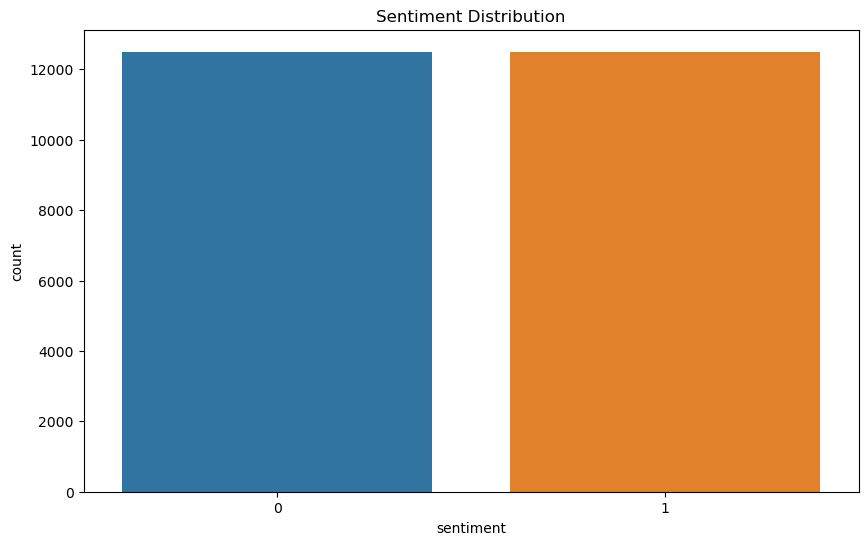

In [12]:
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=train_df)
plt.title('Sentiment Distribution')
plt.show()

In [13]:
#Negative comments value count
negative_comments=train_df[train_df['sentiment']==0].shape[0]

In [14]:
#Positive comments value count
positive_comments=train_df[train_df['sentiment']==1].shape[0]

In [15]:
def remove_html_tags(text):
    return BeautifulSoup(text, "html.parser").get_text()

In [16]:
type(train_df)

pandas.core.frame.DataFrame

In [17]:
train_df['cleaned_sentence'] = train_df['sentence'].apply(remove_html_tags)
test_df['cleaned_sentence'] = test_df['sentence'].apply(remove_html_tags)

/var/folders/2_/vtvr7ld54f195qy1q7yyhwcw0000gn/T/ipykernel_10730/2886006010.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(text, "html.parser").get_text()
/var/folders/2_/vtvr7ld54f195qy1q7yyhwcw0000gn/T/ipykernel_10730/2886006010.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(text, "html.parser").get_text()


In [18]:
type(train_df)

pandas.core.frame.DataFrame

In [19]:
train_df.head()

,sentence,sentiment,cleaned_sentence
0,Working with one of the best Shakespeare sourc...,0,Working with one of the best Shakespeare sourc...
1,"Well...tremors I, the original started off in ...",0,"Well...tremors I, the original started off in ..."
2,Ouch! This one was a bit painful to sit throug...,0,Ouch! This one was a bit painful to sit throug...
3,"I've seen some crappy movies in my life, but t...",0,"I've seen some crappy movies in my life, but t..."
4,"""Carriers"" follows the exploits of two guys an...",0,"""Carriers"" follows the exploits of two guys an..."


In [20]:
train_df.drop(columns=['sentence'], inplace=True)
test_df.drop(columns=['sentence'], inplace=True)

In [21]:
def generate_wordcloud(text,Title):
    wordcloud=WordCloud(
        width=700,
        height=400,
        background_color='black',
        colormap='viridis'
    ).generate(text)
    plt.figure(figsize=(13,13))
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.title(Title)
    plt.show()

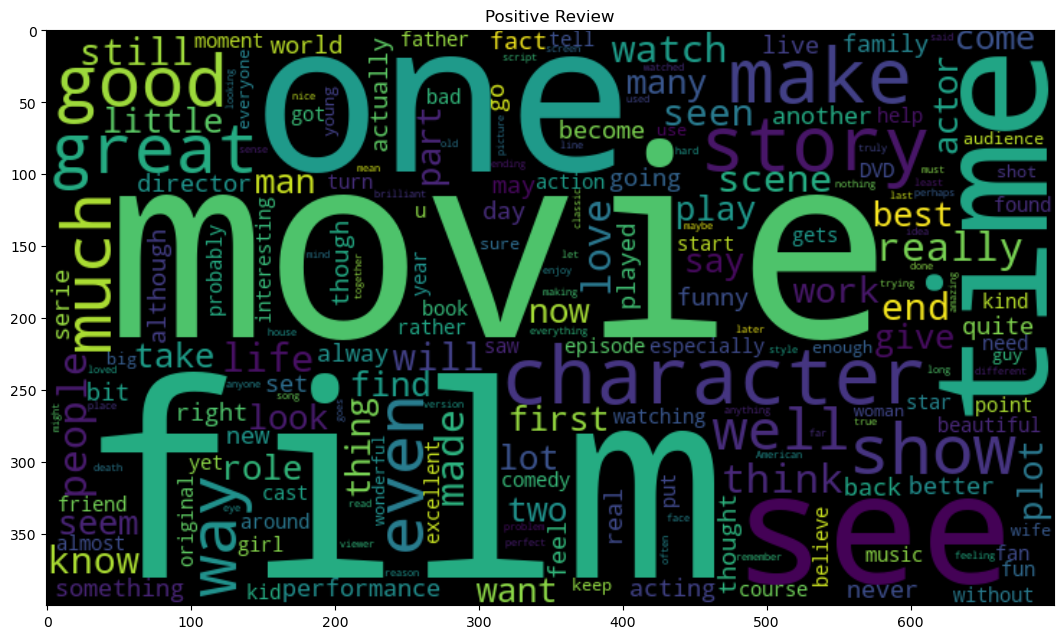

In [22]:
positive= train_df[train_df['sentiment']==1]['cleaned_sentence']
positive_txt=" ".join(positive)
generate_wordcloud(positive_txt,'Positive Review')

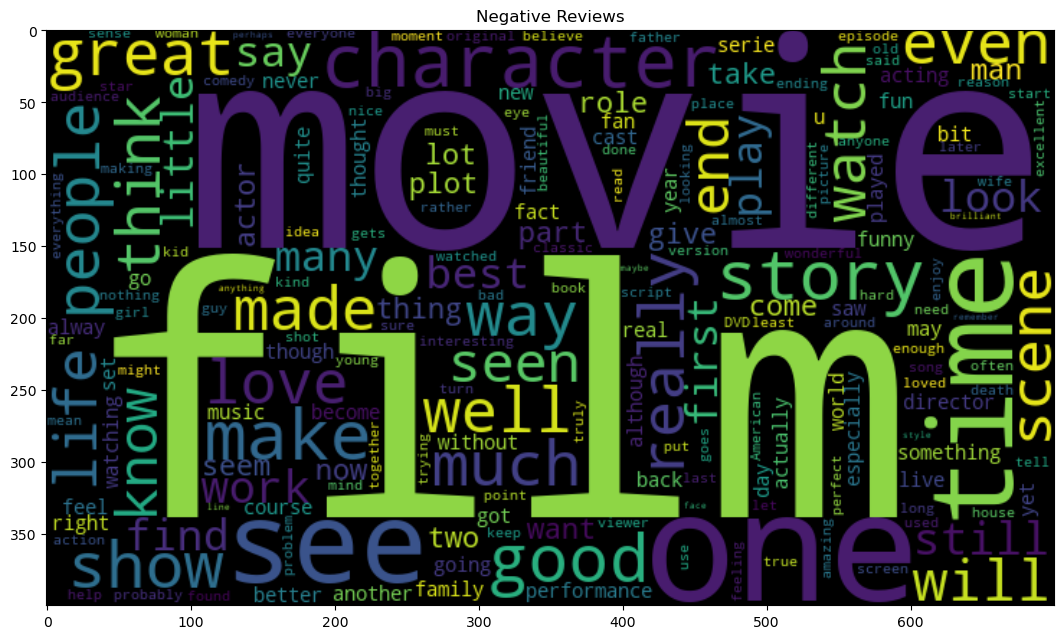

In [23]:
negative=train_df[train_df['sentiment']==1]['cleaned_sentence']
negative_txt=" ".join(negative)
generate_wordcloud(negative_txt,"Negative Reviews")

In [25]:
# Training data
#Reviews = "[CLS] " +train_df['Cleaned_sentence'] + "[SEP]"
Reviews = train_df['cleaned_sentence']
Target = train_df['sentiment']

# Test data
#test_reviews =  "[CLS] " +test_df['Cleaned_sentence'] + "[SEP]"
test_reviews = test_df['cleaned_sentence']
test_targets = test_df['sentiment']